<a href="https://colab.research.google.com/github/Hannah-Xiang/Semi-Supervised-Feature-Selection-for-Imbalanced-Tabular-Data/blob/main/Semi-Supervised-Feature-Selection-for-Imbalanced-Tabular-Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Required installations**

In [41]:
pip install ucimlrepo


In [42]:
pip install imbalanced-learn

## **Importing Libraries**

In [2]:
# === Imports ===
import os
import gc
import glob
import json
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from ucimlrepo import fetch_ucirepo

# Preprocessing & split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Semi-supervised
from sklearn.semi_supervised import LabelPropagation, LabelSpreading, SelfTrainingClassifier

# Feature selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif

# Imbalanced sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Models & metrics
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
)

ModuleNotFoundError: No module named 'ucimlrepo'

In [3]:
# === Drive & cache dir ===
drive.mount("/content/drive")
SAVE_DIR = "/content/drive/MyDrive/credit_cache"
os.makedirs(SAVE_DIR, exist_ok=True)

Mounted at /content/drive


In [4]:
# === Cache helper ===
def save_or_load(filename, generator_func, save_format="csv", force_reload=False):
    """
    General caching mechanism:
    - If the file exists and recomputation is not forced: load directly
    - Otherwise call generator_func to generate and save
    """
    path = os.path.join(SAVE_DIR, filename)

    if os.path.exists(path) and not force_reload:
        print(f"Loaded cached file: {filename}")
        if save_format == "csv":
            return pd.read_csv(path)
        elif save_format == "npy":
            return np.load(path, allow_pickle=True)
    else:
        print(f"Generating and saving: {filename}")
        result = generator_func()
        if save_format == "csv":
            result.to_csv(path, index=False)
        elif save_format == "npy":
            np.save(path, result)
        gc.collect()
        return result

## **Step 1: Data Collection & Loading**

In [46]:
# All feature column names
columnsName = [f"X{i}" for i in range(1, 24)]

def load_data():
    data = fetch_ucirepo(id=350)
    features = data.data.features
    targets = data.data.targets
    df = pd.concat([features, targets], axis=1)
    df.rename(columns={"default payment next month": "Y"}, inplace=True)
    return df

df = save_or_load("step1_raw_data.csv", load_data)


Loaded cached file: step1_raw_data.csv


In [47]:
print(df.shape)

(30000, 24)


In [48]:
print(df.columns)

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'Y'],
      dtype='object')


In [49]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   X1      30000 non-null  int64
 1   X2      30000 non-null  int64
 2   X3      30000 non-null  int64
 3   X4      30000 non-null  int64
 4   X5      30000 non-null  int64
 5   X6      30000 non-null  int64
 6   X7      30000 non-null  int64
 7   X8      30000 non-null  int64
 8   X9      30000 non-null  int64
 9   X10     30000 non-null  int64
 10  X11     30000 non-null  int64
 11  X12     30000 non-null  int64
 12  X13     30000 non-null  int64
 13  X14     30000 non-null  int64
 14  X15     30000 non-null  int64
 15  X16     30000 non-null  int64
 16  X17     30000 non-null  int64
 17  X18     30000 non-null  int64
 18  X19     30000 non-null  int64
 19  X20     30000 non-null  int64
 20  X21     30000 non-null  int64
 21  X22     30000 non-null  int64
 22  X23     30000 non-null  int64
 23  Y       300

In [50]:
print(df.describe())

                   X1            X2            X3            X4            X5  \
count    30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean    167484.322667      1.603733      1.853133      1.551867     35.485500   
std     129747.661567      0.489129      0.790349      0.521970      9.217904   
min      10000.000000      1.000000      0.000000      0.000000     21.000000   
25%      50000.000000      1.000000      1.000000      1.000000     28.000000   
50%     140000.000000      2.000000      2.000000      2.000000     34.000000   
75%     240000.000000      2.000000      2.000000      2.000000     41.000000   
max    1000000.000000      2.000000      6.000000      3.000000     79.000000   

                 X6            X7            X8            X9           X10  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      -0.016700     -0.133767     -0.166200     -0.220667     -0.266200   
std        1.123802      1.197186

In [51]:
print(df.isnull().sum())

X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
X19    0
X20    0
X21    0
X22    0
X23    0
Y      0
dtype: int64


In [52]:
print(df["Y"].value_counts(normalize=True))

Y
0    0.7788
1    0.2212
Name: proportion, dtype: float64


## **Step 2 : Exploratory Data Analysis (EDA)**

In [53]:
# Use cached raw data
df = save_or_load("step1_raw_data.csv", load_data)


Loaded cached file: step1_raw_data.csv


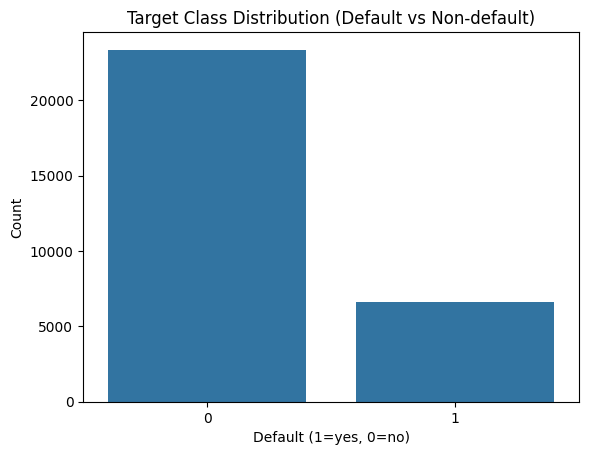

In [54]:

# Target distribution
sns.countplot(x="Y", data=df[["Y"]])
plt.title("Target Class Distribution (Default vs Non-default)")
plt.xlabel("Default (1=yes, 0=no)")
plt.ylabel("Count")
plt.show()

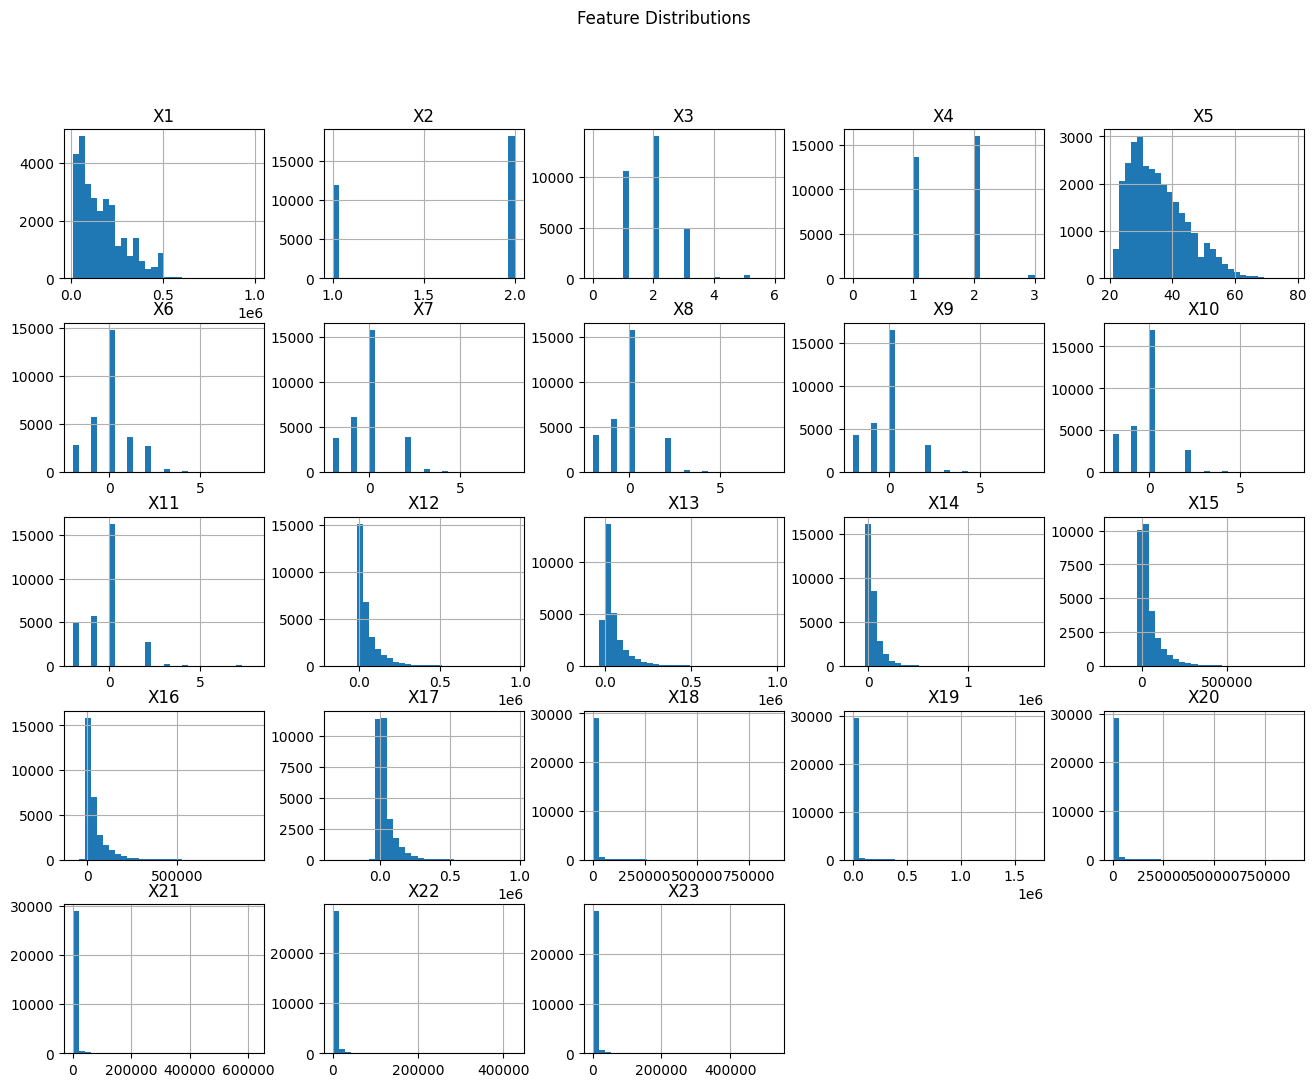

In [55]:
# Feature histograms
df[columnsName].hist(figsize=(16, 12), bins=30)
plt.suptitle("Feature Distributions")
plt.show()

In [56]:
# Distribution of some categorical variables
for col in ["X2", "X3", "X4"]:
    print(col, df[col].value_counts(), "\n")

X2 X2
2    18112
1    11888
Name: count, dtype: int64 

X3 X3
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64 

X4 X4
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64 



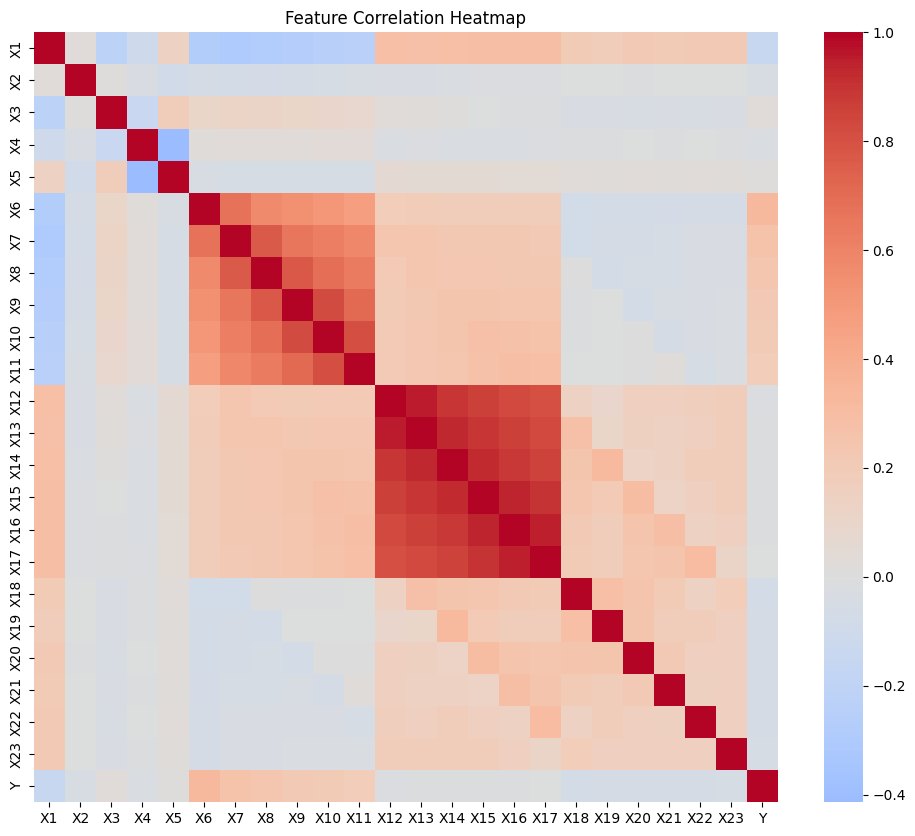

In [57]:

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

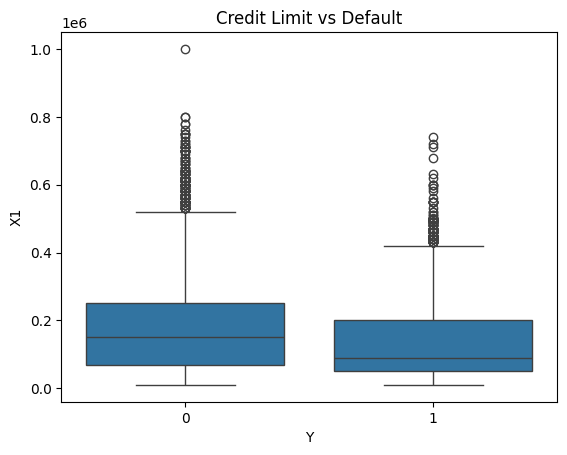

In [58]:
# Some boxplots
sns.boxplot(x="Y", y="X1", data=df)
plt.title("Credit Limit vs Default")
plt.show()

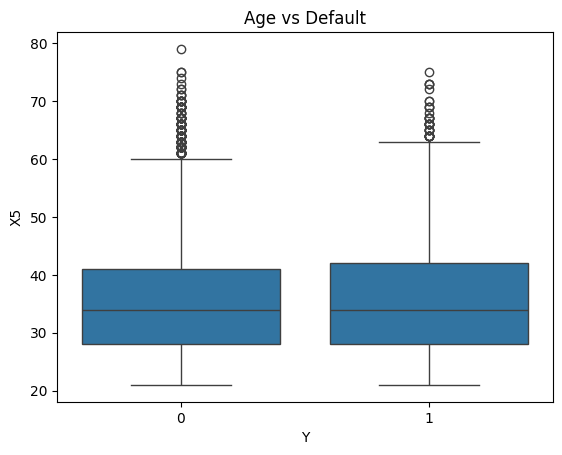

In [59]:
sns.boxplot(x="Y", y="X5", data=df)
plt.title("Age vs Default")
plt.show()

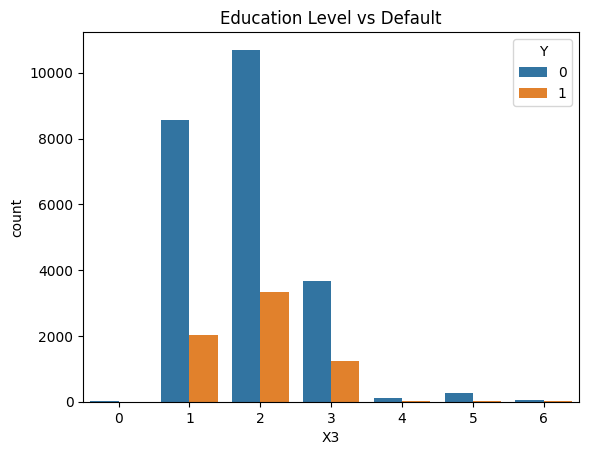

In [60]:
sns.countplot(x="X3", hue="Y", data=df)
plt.title("Education Level vs Default")
plt.show()

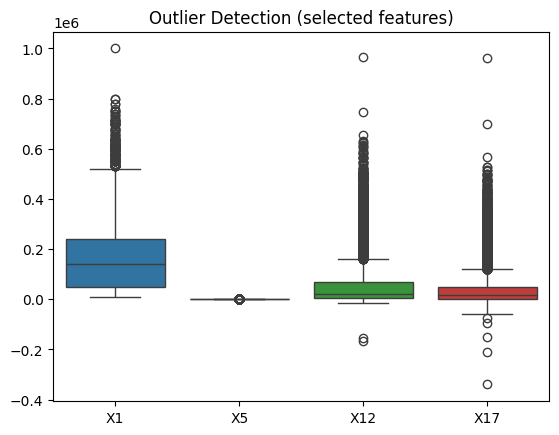

In [61]:
sns.boxplot(data=df[["X1", "X5", "X12", "X17"]])
plt.title("Outlier Detection (selected features)")
plt.show()

## **Step 3: Data Preprocessing**

In [62]:
# Category merging
df["X3"] = df["X3"].replace({0: 4, 5: 4, 6: 4})
df["X4"] = df["X4"].replace({0: 3})

In [63]:
# Bill & repayment amount clipping
bill_features = ["X12", "X13", "X14", "X15", "X16", "X17"]
pay_features = ["X18", "X19", "X20", "X21", "X22", "X23"]

df[bill_features] = df[bill_features].clip(lower=0)
df[pay_features] = df[pay_features].clip(lower=0)

In [64]:
# Standardization
scaler = StandardScaler()
features_scaled = df[columnsName].copy()
scale_cols = bill_features + pay_features + ["X1", "X5"]
features_scaled[scale_cols] = scaler.fit_transform(features_scaled[scale_cols])

In [65]:
def save_split_before_simulation():
    X = features_scaled.copy()
    y = df["Y"].copy()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    return {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
    }

split_data_before_sim = save_or_load(
    "step3_preprocessed.npy", save_split_before_simulation, save_format="npy"
).item()

X_train = split_data_before_sim["X_train"]
X_test = split_data_before_sim["X_test"]
y_train = split_data_before_sim["y_train"]
y_test = split_data_before_sim["y_test"]

print("Data before simulation saved as step3_preprocessed.npy")
print("Train:", X_train.shape, "Test:", X_test.shape)

Loaded cached file: step3_preprocessed.npy
Data before simulation saved as step3_preprocessed.npy
Train: (24000, 23) Test: (6000, 23)


In [66]:
# —— Simulate unlabeled samples (-1) ——
def make_simulated_data():
    y_semi = y_train.copy()
    rng = np.random.RandomState(42)
    mask = rng.rand(len(y_semi)) < 0.3  # 30% become -1
    y_semi[mask] = -1

    df_sim = X_train.copy()
    df_sim["Y"] = y_semi
    df_sim["is_unlabeled"] = mask.astype(int)
    return df_sim

df_simulated = save_or_load(
    "step3_preprocessed_simulated.csv", make_simulated_data, save_format="csv"
)

print("Simulated training data saved as step3_preprocessed_simulated.csv")
print(df_simulated.head())
print(df_simulated["is_unlabeled"].value_counts())

Generating and saving: step3_preprocessed_simulated.csv
Simulated training data saved as step3_preprocessed_simulated.csv
             X1  X2  X3  X4        X5  X6  X7  X8  X9  X10  ...       X16  \
22788 -0.057685   2   2   2 -0.269643   2   2   3   2    0  ...  2.013210   
29006 -0.134759   2   1   2 -0.161156   1  -1  -1  -2   -2  ... -0.663979   
16950 -1.213794   1   2   1  1.574625   1   2   0   0    0  ... -0.528590   
22280  0.404759   2   1   2 -0.703588   0   0   0   0    0  ...  1.502707   
11346  1.098425   2   1   2 -0.378129   1  -2  -1   0    0  ... -0.663979   

            X17       X18       X19       X20       X21       X22       X23  \
22788  2.087018  0.563691 -0.256990 -0.296801  0.081318  0.490940  0.049755   
29006 -0.655098 -0.338742 -0.256990 -0.296801 -0.308063 -0.314136 -0.293382   
16950 -0.513791 -0.341821 -0.201392 -0.232394 -0.289296 -0.294173 -0.237130   
22280  1.604908  0.207476  0.133627  0.151154 -0.001665  0.006585  0.044129   
11346 -0.655098 -0.3

In [67]:
# Clean up large unused objects
plt.close("all")
del df, features_scaled
gc.collect()

4504

## **Step 4: Pseudo-Labeling for Semi-Supervised Learning**

In [68]:
# Reload simulated data and construct y_semi
df_simulated = save_or_load(
    "step3_preprocessed_simulated.csv", make_simulated_data, save_format="csv"
)

Loaded cached file: step3_preprocessed_simulated.csv


In [69]:
y_semi_array = df_simulated["Y"].values
mask_pseudo = (y_semi_array == -1)
print(f"Unlabeled sample ratio: {(mask_pseudo.mean()):.2%}")

Unlabeled sample ratio: 29.68%


In [70]:
def save_pseudo_labels(filename, pseudo_labels, mask_pseudo, model=None):
    df_save = pd.DataFrame({
        "pseudo_label": pseudo_labels,
        "is_unlabeled": mask_pseudo.astype(int),
    })

    if model is not None and hasattr(model, "label_distributions_"):
        conf = model.label_distributions_[mask_pseudo].max(axis=1)
        df_save.loc[mask_pseudo, "confidence"] = conf

    df_save.to_csv(os.path.join(SAVE_DIR, filename), index=False)
    print(f"Saved pseudo labels to {filename}")

In [72]:
# --- LabelPropagation (RBF) ---
lp_rbf = LabelPropagation(kernel="rbf", gamma=20, max_iter=1000)
lp_rbf.fit(X_train, y_semi_array)
pseudo_labels_rbf = lp_rbf.transduction_
print("\n=== LabelPropagation (RBF) ===")
print("Number of pseudo-tags generated:", mask_pseudo.sum())
print(pd.Series(pseudo_labels_rbf[mask_pseudo]).value_counts())
if hasattr(lp_rbf, "label_distributions_"):
    conf = lp_rbf.label_distributions_[mask_pseudo].max(axis=1)
    print(f"Average confidence: {conf.mean():.4f}")

save_pseudo_labels("step4_lp_rbf.csv", pseudo_labels_rbf, mask_pseudo, lp_rbf)


=== LabelPropagation (RBF) ===
Number of pseudo-tags generated: 7122
0    5651
1    1471
Name: count, dtype: int64
Average confidence: 0.9458
Saved pseudo labels to step4_lp_rbf.csv


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=1000 was reached without convergence.
  warnings.warn(


In [73]:
# --- LabelPropagation (KNN) ---
lp_knn = LabelPropagation(kernel="knn", n_neighbors=10, max_iter=1000)
lp_knn.fit(X_train, y_semi_array)
pseudo_labels_knn = lp_knn.transduction_
print("\n=== LabelPropagation (KNN) ===")
print(pd.Series(pseudo_labels_knn[mask_pseudo]).value_counts())
if hasattr(lp_knn, "label_distributions_"):
    conf = lp_knn.label_distributions_[mask_pseudo].max(axis=1)
    print(f"Average confidence: {conf.mean():.4f}")

save_pseudo_labels("step4_lp_knn.csv", pseudo_labels_knn, mask_pseudo, lp_knn)


=== LabelPropagation (KNN) ===
0    6179
1     943
Name: count, dtype: int64
Average confidence: 0.8250
Saved pseudo labels to step4_lp_knn.csv


In [74]:
# --- LabelSpreading (KNN) ---
ls_knn = LabelSpreading(kernel="knn", n_neighbors=10, alpha=0.2, max_iter=1000)
ls_knn.fit(X_train, y_semi_array)
pseudo_labels_ls = ls_knn.transduction_
print("\n=== LabelSpreading (KNN) ===")
print(pd.Series(pseudo_labels_ls[mask_pseudo]).value_counts())
if hasattr(ls_knn, "label_distributions_"):
    conf = ls_knn.label_distributions_[mask_pseudo].max(axis=1)
    print(f"Average confidence: {conf.mean():.4f}")

save_pseudo_labels("step4_ls_knn.csv", pseudo_labels_ls, mask_pseudo, ls_knn)


=== LabelSpreading (KNN) ===
0    6152
1     970
Name: count, dtype: int64
Average confidence: 0.8281
Saved pseudo labels to step4_ls_knn.csv


## **Step 5: Feature Selection**

In [75]:
# Load three sets of pseudo labels
pseudo_files = {
    "LabelPropagation-RBF": os.path.join(SAVE_DIR, "step4_lp_rbf.csv"),
    "LabelPropagation-KNN": os.path.join(SAVE_DIR, "step4_lp_knn.csv"),
    "LabelSpreading-RBF": os.path.join(SAVE_DIR, "step4_ls_knn.csv"),
}

pseudo_label_sets = {}
for name, file in pseudo_files.items():
    df_pseudo = pd.read_csv(file)
    pseudo_label_sets[name] = df_pseudo["pseudo_label"].values
    print(f"{name} loaded, shape = {df_pseudo.shape}")

LabelPropagation-RBF loaded, shape = (24000, 3)
LabelPropagation-KNN loaded, shape = (24000, 3)
LabelSpreading-RBF loaded, shape = (24000, 3)


In [76]:
def select_features(X, y, method):
    """
    method: 'none' | 'l1' | 'mutualinfo'
    """
    if method == "none":
        return X.columns.tolist()

    if method == "l1":
        clf = LogisticRegression(
            penalty="l1", solver="liblinear", random_state=42, max_iter=2000
        )
        clf.fit(X, y)
        coef = np.abs(clf.coef_[0])
        top10_idx = np.argsort(coef)[-10:]
        return X.columns[top10_idx].tolist()

    if method == "mutualinfo":
        mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42)
        top10_idx = np.argsort(mi_scores)[-10:]
        return X.columns[top10_idx].tolist()

    raise ValueError("method must be 'none', 'l1', or 'mutualinfo'")


In [77]:
feature_selection_results = {}
rows = []

for label_method, pseudo_labels in pseudo_label_sets.items():
    y_final = np.where(y_semi_array == -1, pseudo_labels, y_semi_array)
    feature_selection_results[label_method] = {}

    for fs_method in ["none", "l1", "mutualinfo"]:
        selected = select_features(X_train, y_final, fs_method)
        feature_selection_results[label_method][fs_method] = selected

        print(f"\n=== {label_method} | {fs_method.upper()} ===")
        print(f"Selected {len(selected)} features:")
        print(selected)

        rows.append({
            "PseudoLabel_Method": label_method,
            "FeatureSelection_Method": fs_method,
            "Num_Features": len(selected),
            "Selected_Features": selected,
        })

df_feature_summary = pd.DataFrame(rows)
print("\n=== Step 5 Feature Selection Summary ===")
display(df_feature_summary)


=== LabelPropagation-RBF | NONE ===
Selected 23 features:
['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23']

=== LabelPropagation-RBF | L1 ===
Selected 10 features:
['X4', 'X3', 'X8', 'X19', 'X17', 'X16', 'X13', 'X18', 'X12', 'X6']

=== LabelPropagation-RBF | MUTUALINFO ===
Selected 10 features:
['X21', 'X1', 'X19', 'X18', 'X11', 'X10', 'X9', 'X8', 'X7', 'X6']

=== LabelPropagation-KNN | NONE ===
Selected 23 features:
['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23']

=== LabelPropagation-KNN | L1 ===
Selected 10 features:
['X1', 'X4', 'X2', 'X3', 'X8', 'X13', 'X19', 'X18', 'X12', 'X6']

=== LabelPropagation-KNN | MUTUALINFO ===
Selected 10 features:
['X20', 'X19', 'X1', 'X18', 'X11', 'X10', 'X9', 'X8', 'X7', 'X6']

=== LabelSpreading-RBF | NONE ===
Selected 23 features:
['X1', 'X2'

,PseudoLabel_Method,FeatureSelection_Method,Num_Features,Selected_Features
0,LabelPropagation-RBF,none,23,"[X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11,..."
1,LabelPropagation-RBF,l1,10,"[X4, X3, X8, X19, X17, X16, X13, X18, X12, X6]"
2,LabelPropagation-RBF,mutualinfo,10,"[X21, X1, X19, X18, X11, X10, X9, X8, X7, X6]"
3,LabelPropagation-KNN,none,23,"[X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11,..."
4,LabelPropagation-KNN,l1,10,"[X1, X4, X2, X3, X8, X13, X19, X18, X12, X6]"
5,LabelPropagation-KNN,mutualinfo,10,"[X20, X19, X1, X18, X11, X10, X9, X8, X7, X6]"
6,LabelSpreading-RBF,none,23,"[X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11,..."
7,LabelSpreading-RBF,l1,10,"[X2, X7, X4, X3, X8, X13, X19, X18, X12, X6]"
8,LabelSpreading-RBF,mutualinfo,10,"[X19, X20, X1, X18, X11, X10, X9, X8, X7, X6]"


In [78]:
# Save dictionary results & summary table
_ = save_or_load(
    "step5_feature_selection_results.csv",
    lambda: pd.DataFrame(feature_selection_results),
    save_format="csv",
    force_reload=True,
)

_ = save_or_load(
    "step5_feature_selection_summary.csv",
    lambda: df_feature_summary,
    save_format="csv",
    force_reload=True,
)

Generating and saving: step5_feature_selection_results.csv
Generating and saving: step5_feature_selection_summary.csv


## **Step 6: Imbalanced Data Handling**

In [79]:
# Reuse pseudo_label_sets (already defined in Step 5)
# df_feature_summary already contains: PseudoLabel_Method / FeatureSelection_Method / Selected_Features

def handle_imbalance(X, y, method="smote"):
    if method == "smote":
        sampler = SMOTE(random_state=42)
    elif method == "under":
        sampler = RandomUnderSampler(random_state=42)
    else:
        raise ValueError("method must be 'smote' or 'under'")
    return sampler.fit_resample(X, y)


In [87]:
imbalance_results = {}
rows_imb = []

for _, row in df_feature_summary.iterrows():
    label_method = row["PseudoLabel_Method"]
    fs_method = row["FeatureSelection_Method"]
    selected_feats = row["Selected_Features"]

    # Pseudo-label fusion
    y_final = np.where(
        y_semi_array == -1, pseudo_label_sets[label_method], y_semi_array
    )

    X_selected = X_train[selected_feats]
    print(f"\n=== {label_method} | {fs_method.upper()} ===")
    print(f"Original distribution: {Counter(y_final)}")

    imbalance_results.setdefault(label_method, {})
    imbalance_results[label_method].setdefault(fs_method, {})

    for sampler_name in ["smote", "under"]:
        X_res, y_res = handle_imbalance(X_selected, y_final, sampler_name)
        imbalance_results[label_method][fs_method][sampler_name] = {
            "X_shape": X_res.shape,
            "y_distribution": dict(Counter(y_res)),
        }
        print(f"After {sampler_name.upper()}: {Counter(y_res)}")

        # Save resampled data
        df_res = pd.DataFrame(np.column_stack((X_res, y_res)), columns=list(X_selected.columns) + ["Y"])

        out_name = f"step6_{label_method}_{fs_method}_{sampler_name}.csv"
        df_res.to_csv(os.path.join(SAVE_DIR, out_name), index=False)

        rows_imb.append({
            "PseudoLabel_Method": label_method,
            "FeatureSelection_Method": fs_method,
            "Sampler": sampler_name.upper(),
            "X_shape": X_res.shape,
            "y_distribution": dict(Counter(y_res)),
        })

df_imbalance_summary = pd.DataFrame(rows_imb)
print("\n=== Step 6 Imbalance Summary ===\n")
display(df_imbalance_summary)


=== LabelPropagation-RBF | NONE ===
Original distribution: Counter({np.int64(0): 18809, np.int64(1): 5191})
After SMOTE: Counter({np.int64(0): 18809, np.int64(1): 18809})
After UNDER: Counter({np.int64(0): 5191, np.int64(1): 5191})

=== LabelPropagation-RBF | L1 ===
Original distribution: Counter({np.int64(0): 18809, np.int64(1): 5191})
After SMOTE: Counter({np.int64(0): 18809, np.int64(1): 18809})
After UNDER: Counter({np.int64(0): 5191, np.int64(1): 5191})

=== LabelPropagation-RBF | MUTUALINFO ===
Original distribution: Counter({np.int64(0): 18809, np.int64(1): 5191})
After SMOTE: Counter({np.int64(0): 18809, np.int64(1): 18809})
After UNDER: Counter({np.int64(0): 5191, np.int64(1): 5191})

=== LabelPropagation-KNN | NONE ===
Original distribution: Counter({np.int64(0): 19337, np.int64(1): 4663})
After SMOTE: Counter({np.int64(0): 19337, np.int64(1): 19337})
After UNDER: Counter({np.int64(0): 4663, np.int64(1): 4663})

=== LabelPropagation-KNN | L1 ===
Original distribution: Counte

,PseudoLabel_Method,FeatureSelection_Method,Sampler,X_shape,y_distribution
0,LabelPropagation-RBF,none,SMOTE,"(37618, 23)","{0: 18809, 1: 18809}"
1,LabelPropagation-RBF,none,UNDER,"(10382, 23)","{0: 5191, 1: 5191}"
2,LabelPropagation-RBF,l1,SMOTE,"(37618, 10)","{0: 18809, 1: 18809}"
3,LabelPropagation-RBF,l1,UNDER,"(10382, 10)","{0: 5191, 1: 5191}"
4,LabelPropagation-RBF,mutualinfo,SMOTE,"(37618, 10)","{0: 18809, 1: 18809}"
5,LabelPropagation-RBF,mutualinfo,UNDER,"(10382, 10)","{0: 5191, 1: 5191}"
6,LabelPropagation-KNN,none,SMOTE,"(38674, 23)","{0: 19337, 1: 19337}"
7,LabelPropagation-KNN,none,UNDER,"(9326, 23)","{0: 4663, 1: 4663}"
8,LabelPropagation-KNN,l1,SMOTE,"(38674, 10)","{0: 19337, 1: 19337}"
9,LabelPropagation-KNN,l1,UNDER,"(9326, 10)","{0: 4663, 1: 4663}"


In [88]:
# If saving json, convert keys to str (otherwise np.int64 will cause errors)
'''
with open(os.path.join(SAVE_DIR, "step6_imbalance_results.json"), "w") as f:
    json.dump(imbalance_results, f, indent=4, default=str)

df_imbalance_summary.to_csv(
    os.path.join(SAVE_DIR, "step6_imbalance_summary.csv"), index=False
)
print("Step 6 results saved to JSON and CSV.")'''

'\nwith open(os.path.join(SAVE_DIR, "step6_imbalance_results.json"), "w") as f:\n    json.dump(imbalance_results, f, indent=4, default=str)\n\ndf_imbalance_summary.to_csv(\n    os.path.join(SAVE_DIR, "step6_imbalance_summary.csv"), index=False\n)\nprint("Step 6 results saved to JSON and CSV.")'

## **Step 7: Model Training**

In [89]:
supervised_models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        eval_metric="logloss",
    ),
}

base_lr = LogisticRegression(max_iter=2000, random_state=42)
semi_supervised_models = {
    "SelfTraining(LR)": SelfTrainingClassifier(base_lr, threshold=0.8, max_iter=50)
}

In [90]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = np.nan

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "AUC": auc,
    }

In [92]:
# Load all step6 resampled data
step6_files = glob.glob(os.path.join(SAVE_DIR, "step6_*.csv"))
print(f"Detected {len(step6_files)} Step 6 data files")

model_results = []

for file in step6_files:
    df_step6 = pd.read_csv(file)
    X = df_step6.drop("Y", axis=1)
    y = df_step6["Y"]

    # Align test set columns
    X_test_fs = X_test[X.columns]

    # Parse meta info from filename
    temp = os.path.basename(file).split("step6_")[1].replace(".csv", "")
    pseudo_method, fs_method, sampler = temp.split("_")

    # Supervised models
    for model_name, model in supervised_models.items():
        scores = evaluate_model(model, X, y, X_test_fs, y_test)
        model_results.append({
            "PseudoLabel_Method": pseudo_method,
            "FeatureSelection_Method": fs_method,
            "Sampler": sampler,
            "Model": model_name,
            **scores,
        })
        print(f"{pseudo_method} | {fs_method} | {sampler} | {model_name} completed")

    # Self-training semi-supervised (use original X_train + y_semi_array)
    for model_name, model in semi_supervised_models.items():
        y_semi_input = np.where(
            y_semi_array == -1, pseudo_label_sets[pseudo_method], y_semi_array
        )
        model.fit(X_train[X.columns], y_semi_input)
        y_pred = model.predict(X_test_fs)
        scores = {
            "Accuracy": accuracy_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "AUC": roc_auc_score(y_test, model.predict_proba(X_test_fs)[:, 1]),
        }
        model_results.append({
            "PseudoLabel_Method": pseudo_method,
            "FeatureSelection_Method": fs_method,
            "Sampler": sampler,
            "Model": model_name,
            **scores,
        })
        print(f"{pseudo_method} | {fs_method} | {sampler} | {model_name} completed (Self-training)")

Detected 18 Step 6 data files
LabelPropagation-RBF | none | smote | LogisticRegression completed
LabelPropagation-RBF | none | smote | RandomForest completed
LabelPropagation-RBF | none | smote | XGBoost completed


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


LabelPropagation-RBF | none | smote | SelfTraining(LR) completed (Self-training)
LabelPropagation-RBF | none | under | LogisticRegression completed
LabelPropagation-RBF | none | under | RandomForest completed
LabelPropagation-RBF | none | under | XGBoost completed


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


LabelPropagation-RBF | none | under | SelfTraining(LR) completed (Self-training)
LabelPropagation-RBF | l1 | smote | LogisticRegression completed
LabelPropagation-RBF | l1 | smote | RandomForest completed
LabelPropagation-RBF | l1 | smote | XGBoost completed
LabelPropagation-RBF | l1 | smote | SelfTraining(LR) completed (Self-training)
LabelPropagation-RBF | l1 | under | LogisticRegression completed


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


LabelPropagation-RBF | l1 | under | RandomForest completed
LabelPropagation-RBF | l1 | under | XGBoost completed
LabelPropagation-RBF | l1 | under | SelfTraining(LR) completed (Self-training)


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


LabelPropagation-RBF | mutualinfo | smote | LogisticRegression completed
LabelPropagation-RBF | mutualinfo | smote | RandomForest completed
LabelPropagation-RBF | mutualinfo | smote | XGBoost completed
LabelPropagation-RBF | mutualinfo | smote | SelfTraining(LR) completed (Self-training)
LabelPropagation-RBF | mutualinfo | under | LogisticRegression completed


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


LabelPropagation-RBF | mutualinfo | under | RandomForest completed
LabelPropagation-RBF | mutualinfo | under | XGBoost completed
LabelPropagation-RBF | mutualinfo | under | SelfTraining(LR) completed (Self-training)


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


LabelPropagation-KNN | none | smote | LogisticRegression completed
LabelPropagation-KNN | none | smote | RandomForest completed
LabelPropagation-KNN | none | smote | XGBoost completed


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


LabelPropagation-KNN | none | smote | SelfTraining(LR) completed (Self-training)
LabelPropagation-KNN | none | under | LogisticRegression completed
LabelPropagation-KNN | none | under | RandomForest completed
LabelPropagation-KNN | none | under | XGBoost completed


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


LabelPropagation-KNN | none | under | SelfTraining(LR) completed (Self-training)
LabelPropagation-KNN | l1 | smote | LogisticRegression completed
LabelPropagation-KNN | l1 | smote | RandomForest completed
LabelPropagation-KNN | l1 | smote | XGBoost completed
LabelPropagation-KNN | l1 | smote | SelfTraining(LR) completed (Self-training)
LabelPropagation-KNN | l1 | under | LogisticRegression completed


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


LabelPropagation-KNN | l1 | under | RandomForest completed
LabelPropagation-KNN | l1 | under | XGBoost completed
LabelPropagation-KNN | l1 | under | SelfTraining(LR) completed (Self-training)
LabelPropagation-KNN | mutualinfo | smote | LogisticRegression completed


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


LabelPropagation-KNN | mutualinfo | smote | RandomForest completed
LabelPropagation-KNN | mutualinfo | smote | XGBoost completed
LabelPropagation-KNN | mutualinfo | smote | SelfTraining(LR) completed (Self-training)
LabelPropagation-KNN | mutualinfo | under | LogisticRegression completed


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


LabelPropagation-KNN | mutualinfo | under | RandomForest completed
LabelPropagation-KNN | mutualinfo | under | XGBoost completed
LabelPropagation-KNN | mutualinfo | under | SelfTraining(LR) completed (Self-training)


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


LabelSpreading-RBF | none | smote | LogisticRegression completed
LabelSpreading-RBF | none | smote | RandomForest completed
LabelSpreading-RBF | none | smote | XGBoost completed


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


LabelSpreading-RBF | none | smote | SelfTraining(LR) completed (Self-training)
LabelSpreading-RBF | none | under | LogisticRegression completed
LabelSpreading-RBF | none | under | RandomForest completed
LabelSpreading-RBF | none | under | XGBoost completed


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


LabelSpreading-RBF | none | under | SelfTraining(LR) completed (Self-training)
LabelSpreading-RBF | l1 | smote | LogisticRegression completed
LabelSpreading-RBF | l1 | smote | RandomForest completed
LabelSpreading-RBF | l1 | smote | XGBoost completed
LabelSpreading-RBF | l1 | smote | SelfTraining(LR) completed (Self-training)
LabelSpreading-RBF | l1 | under | LogisticRegression completed


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


LabelSpreading-RBF | l1 | under | RandomForest completed
LabelSpreading-RBF | l1 | under | XGBoost completed
LabelSpreading-RBF | l1 | under | SelfTraining(LR) completed (Self-training)
LabelSpreading-RBF | mutualinfo | smote | LogisticRegression completed


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


LabelSpreading-RBF | mutualinfo | smote | RandomForest completed
LabelSpreading-RBF | mutualinfo | smote | XGBoost completed
LabelSpreading-RBF | mutualinfo | smote | SelfTraining(LR) completed (Self-training)
LabelSpreading-RBF | mutualinfo | under | LogisticRegression completed


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


LabelSpreading-RBF | mutualinfo | under | RandomForest completed
LabelSpreading-RBF | mutualinfo | under | XGBoost completed
LabelSpreading-RBF | mutualinfo | under | SelfTraining(LR) completed (Self-training)


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_self_training.py:288: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


In [1]:
# Save aggregated results
df_model_results = pd.DataFrame(model_results)
df_model_results.to_csv(os.path.join(SAVE_DIR, "step7_model_results.csv"), index=False)
print("Step 7 model results saved to step7_model_results.csv")
display(df_model_results)

NameError: name 'pd' is not defined